Notebook for: GPR on the Hebeler CEFT EOS

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp

import dickandballs as db
import helpers as hel

## Loading EOS:

In [2]:
ceft = np.loadtxt('EOS/ceft/ceft_hebeler.dat')
n, _, p_lower, e_lower, _,_,_,_,_,_,_,_, p_upper, e_upper, _, _, _ = ceft.T

p_avg = (p_upper+p_lower)/2
e_avg = (e_upper+e_lower)/2

p_width = p_upper-p_lower
e_width = e_upper-e_lower

cs2_avg = np.gradient(p_avg, e_avg) #dp/de


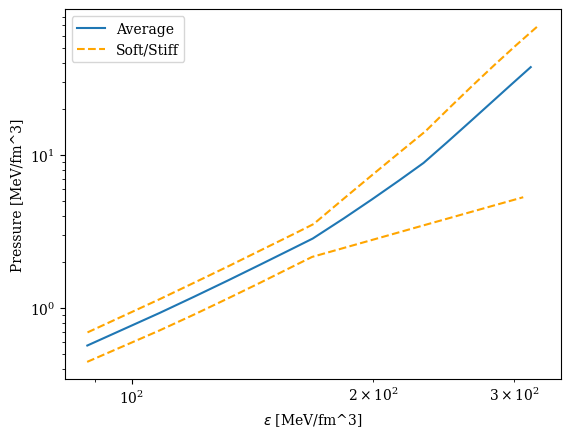

In [3]:
plt.rcParams["font.family"] = "serif"

plt.plot(e_avg, p_avg, label='Average')
plt.plot(e_lower, p_lower, '--', color='orange')
plt.plot(e_upper, p_upper, '--', color='orange', label='Soft/Stiff')
#plt.plot(e_avg+e_width/2, p_avg+p_width/2, color='red', label='Lower/Upper CI')
#plt.plot(e_avg-e_width/2, p_avg-p_width/2, color='red')
plt.ylabel('Pressure [MeV/fm^3]')
plt.xlabel(r'$\epsilon$ [MeV/fm^3]')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

# this looks like the hebeler paper fig 12 (truncated)

Error Propogation method is cancelled, c.f `classes.ipynb`

## Getting sound speed

In [4]:
cs2_lower = np.gradient(p_lower, e_lower) #dp/de
cs2_upper = np.gradient(p_upper, e_upper) #dp/de
cs2_crude_avg = (cs2_upper+cs2_lower)/2
cs2_crude_width = cs2_upper-cs2_lower
cs2_crude_sigma = hel.CI_to_sigma(cs2_crude_width)

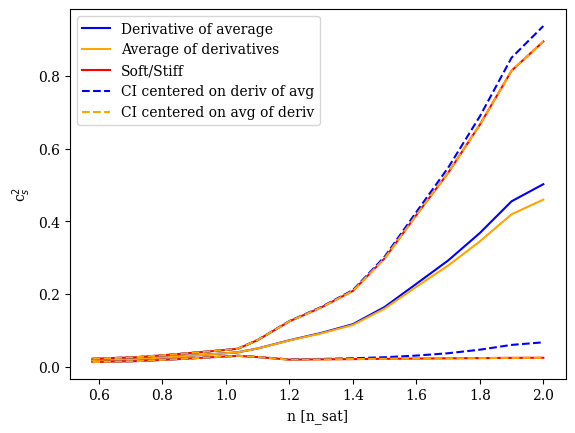

In [5]:
plt.plot(n, cs2_avg, color='blue', label='Derivative of average')
plt.plot(n, cs2_crude_avg, color='orange', label='Average of derivatives')


plt.plot(n, cs2_lower, color='red')
plt.plot(n, cs2_upper, color='red', label='Soft/Stiff')

plt.plot(n, cs2_avg+cs2_crude_width/2, '--', color='blue', label='CI centered on deriv of avg')
plt.plot(n, cs2_avg-cs2_crude_width/2, '--', color='blue')

plt.plot(n, cs2_crude_avg+cs2_crude_width/2, '--', color='orange', label='CI centered on avg of deriv')
plt.plot(n, cs2_crude_avg-cs2_crude_width/2, '--', color='orange')


plt.ylabel(r'c$_s^2$')
plt.xlabel('n [n_sat]')
plt.legend()
plt.show()



unsure whether to use $\frac{dP_{avg}}{d\epsilon_{avg}}$ as $(c_s^2)_{avg}$ (derivative of averages)

or $\frac{(c_s^2)_{upper}+(c_s^2)_{lower}}{2}$ as $(c_s^2)_{avg}$ (average of derivatives)

for now use average of derivatives, in the code written with descriptor of 'crude' as when CI is centered on this, it overlaps with the bounds

## Getting phi:

Using average of get_phis for the same reason. We can justify this as keeping the band (soft to stiff EOS) until the very end and only getting the average to do the regression

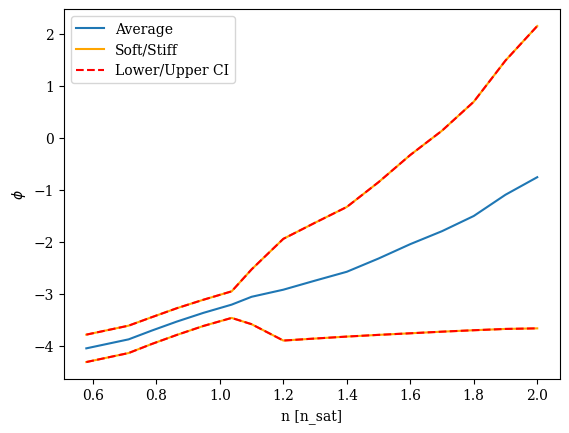

In [6]:
phi_lower = hel.get_phi(cs2_lower)
phi_upper = hel.get_phi(cs2_upper)
phi_width = phi_upper-phi_lower
phi_avg = (phi_upper+phi_lower)/2
phi_sigma = hel.CI_to_sigma(phi_width)

plt.plot(n, phi_avg, label='Average')
plt.plot(n, phi_lower, color='orange')
plt.plot(n, phi_upper, color='orange', label='Soft/Stiff')
plt.plot(n, phi_avg+phi_width/2, '--', color='red', label='Lower/Upper CI')
plt.plot(n, phi_avg-phi_width/2, '--', color='red')
plt.ylabel(r'$\phi$')
plt.xlabel('n [n_sat]')
plt.legend()
plt.show()


## Kernel

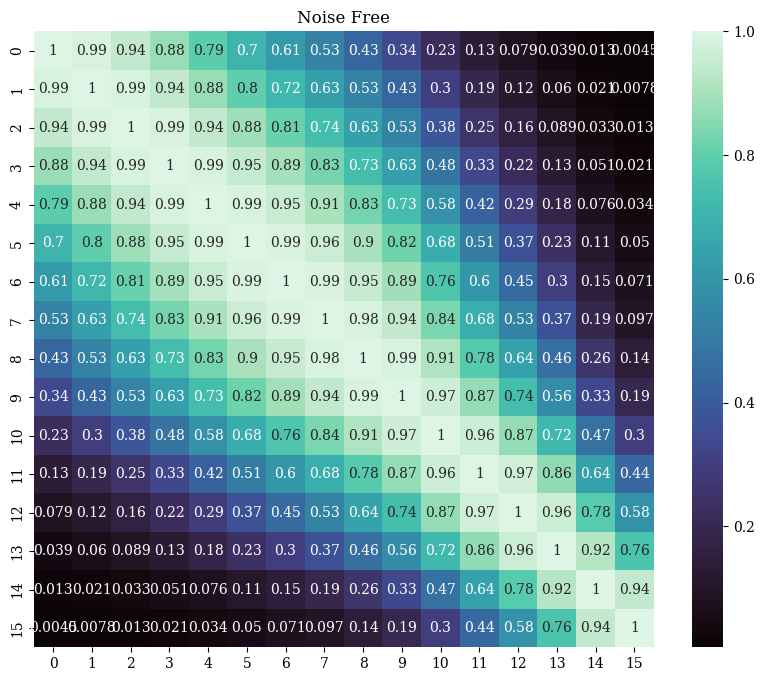

In [7]:
kern = db.Kernel('SE', sigma = 1, l = 1)
K11 = kern.compute(phi_avg)
kern.visualise_kernel(K11, title='Noise Free')

# Noise analysis

Constant Noise:

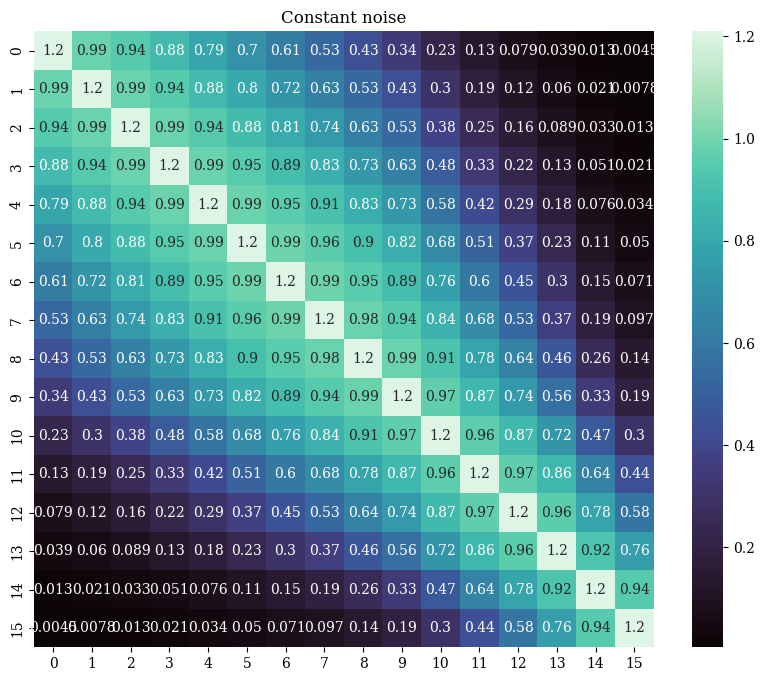

In [8]:
noiseconst_kern = K11 + np.eye(len(phi_sigma))*(phi_sigma[6]**2)
kern.visualise_kernel(noiseconst_kern, 'Constant noise')


## Naive diagonal noise addition

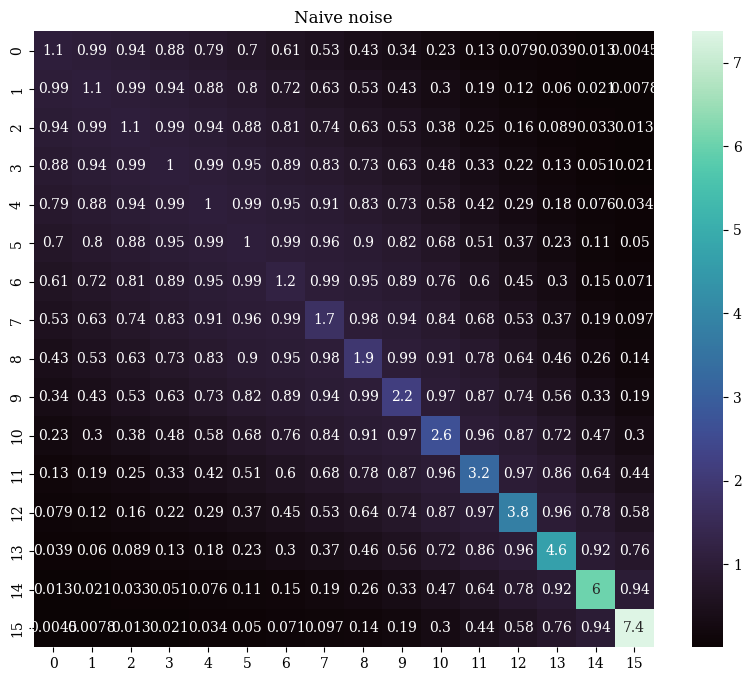

In [9]:
noise_kern = K11 + np.diag(phi_sigma**2)
kern.visualise_kernel(noise_kern, 'Naive noise')


## GPR on Naive Noise

In [10]:
n_crust = 0.07596

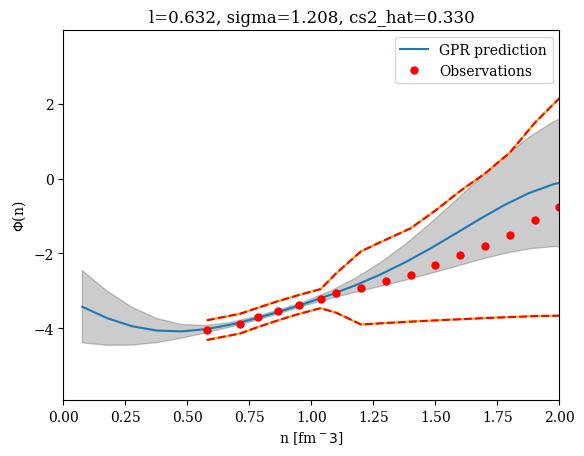

In [11]:
x_test = np.linspace(n_crust, 20, 200) # number density, starting val is ending val of n crust

x_train = n
cs2_train = cs2_crude_avg

phi_train = phi_avg
train_noise = phi_sigma**2

cs2_hat, nu_hat, l_hat = hel.get_hype_samples()
kernel = db.Kernel('SE', sigma=nu_hat, l=l_hat)
gp = db.GP(kernel, hel.get_phi(cs2_hat))
gp.fit(x_train, x_test, phi_train, var_f = train_noise, stabilise=True)

phi_test, sig = gp.posterior()


plt.rcParams["font.family"] = "serif"

plt.plot(x_test, phi_test[0], label=f'GPR prediction')
plt.plot(x_train, phi_train, 'r.', markersize=10, label='Observations')
plt.fill_between(x_test.ravel(), phi_test[0] - 1.96 * sig, phi_test[0] + 1.96 * sig, alpha=0.2, color='k')
plt.xlabel('n [fm$^-3$]')
plt.ylabel(r'$\Phi$(n)')
plt.title(f"l={l_hat:.3f}, sigma={nu_hat:.3f}, cs2_hat={cs2_hat:.3f}")
plt.legend()

plt.plot(n, phi_lower, color='orange')
plt.plot(n, phi_upper, color='orange', label='Soft/Stiff')
plt.plot(n, phi_avg+phi_width/2, '--', color='red', label='Lower/Upper CI')
plt.plot(n, phi_avg-phi_width/2, '--', color='red')

plt.xlim(0,2)
plt.show()



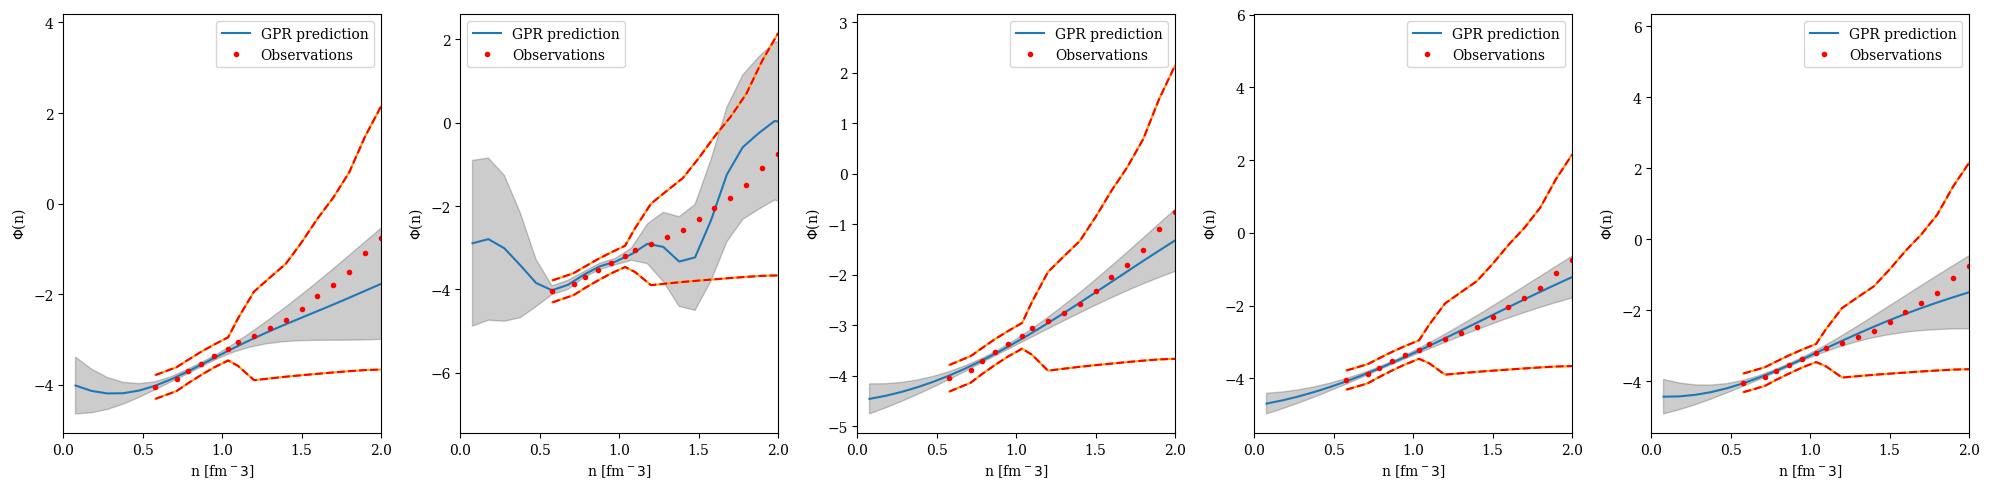

In [17]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    cs2_hat, nu_hat, l_hat = hel.get_hype_samples()
    kernel = db.Kernel('SE', sigma=nu_hat, l=l_hat)
    gp = db.GP(kernel, hel.get_phi(cs2_hat))
    gp.fit(x_train, x_test, phi_train, var_f=train_noise, stabilise=True)

    phi_test, sig = gp.posterior()

    # Plot cs2 vs n in the top row

    axs[i].plot(x_test, phi_test[0], label=f'GPR prediction')
    axs[i].plot(x_train, phi_train, 'r.', label='Observations')
    axs[i].fill_between(x_test.ravel(), phi_test[0] - 1.96 * sig, phi_test[0] + 1.96 * sig, alpha=0.2, color='k')
    axs[i].set_xlabel('n [fm$^-3$]')
    axs[i].set_ylabel(r'$\Phi$(n)')
    #axs[i].title(f"l={l_hat:.3f}, sigma={nu_hat:.3f}, cs2_hat={cs2_hat:.3f}")
    axs[i].legend()

    axs[i].plot(n, phi_lower, color='orange')
    axs[i].plot(n, phi_upper, color='orange', label='Soft/Stiff')
    axs[i].plot(n, phi_avg+phi_width/2, '--', color='red', label='Lower/Upper CI')
    axs[i].plot(n, phi_avg-phi_width/2, '--', color='red')
    axs[i].set_xlim(0,2)

plt.rcParams["font.family"] = "serif"
plt.tight_layout()
plt.xlim(0,2)
plt.show()

# MCMC to find optimal hyperparameters

MH inputs:
* a likelihood function
* initial params
* std of params to explore
* number of iterations

GP:
* has a likelihood function. 
* params to be explored are set in Kernel. GP has instance of Kernel
* params are changed, Kernel changes, likelihood changes
    * ~~TODO: Should refractor GP so that likelihood is entirely self-contained, some overhead removed by not fitted for non-optimal hypeparams~~


### Result of this: Do not need to estimate uncertainty, we can be okay with GPR uncertainty, don't need chiral uncertainty at points away from the training points because CEFT cannot probe those regions, we are okay with using the eq 2 in the Goldberg paper

In [13]:
def m_h_gpr(iterations, initial_params, proposal_std, x, f, var_f=None, stabilise=False, jitter_value=10e-10):
    """ 
    only works for SE kernel?
    params must always have sigma first then l
    """
    samples = []
    accepted = 0

    current_theta = np.array(initial_params) # initial params

    kernel = db.Kernel('SE', sigma=current_theta[0], l=current_theta[1])
    gp = db.GP(kernel, hel.get_phi(cs2_hat))

    current_logL = gp.get_log_likelihood(x, f, var_f, stabilise, jitter_value)
    
    for i in range(iterations):
        # proposing a new point
        proposed_theta = current_theta + np.random.normal(scale=proposal_std, size=current_theta.shape)

        # changing hyperparams
        gp.kernel.params.update(sigma=proposed_theta[0], l=proposed_theta[1]) 

        # calculating the likelihood of the proposed point
        proposed_logL = gp.get_log_likelihood(x, f, var_f, stabilise, jitter_value)

        # calculating the acceptance ratio
        a = np.exp(proposed_logL - current_logL) #log(L1/L2) = logL1 - logL2
        acceptance_ratio = min(1, a) # α=min{new_like/old_like,1}
        # accept the proposed point?
        random_number = np.random.rand() #u∼Unif(0,1)
        if random_number <= acceptance_ratio: # u≤α
            current_theta = proposed_theta
            current_logL = proposed_logL
            accepted += 1
        
        # saving the current parameters to the samples list
        samples.append(current_theta.copy())
    
    acceptance_rate = accepted / iterations

    return np.array(samples), acceptance_rate

In [14]:
x_train = n
cs2_train = cs2_crude_avg
phi_train = phi_avg
train_noise = phi_sigma**2

In [15]:
iteration = 1000

cs2_hat, nu_hat, l_hat = hel.get_hype_samples()
init_param = [nu_hat, l_hat]
param_std = [0.0001, 1]

samples, acceptance_rate = m_h_gpr(iteration, init_param, param_std, x_train, phi_train, train_noise)

print(f"Acceptance Rate: {acceptance_rate:.2f}")


Acceptance Rate: 0.48


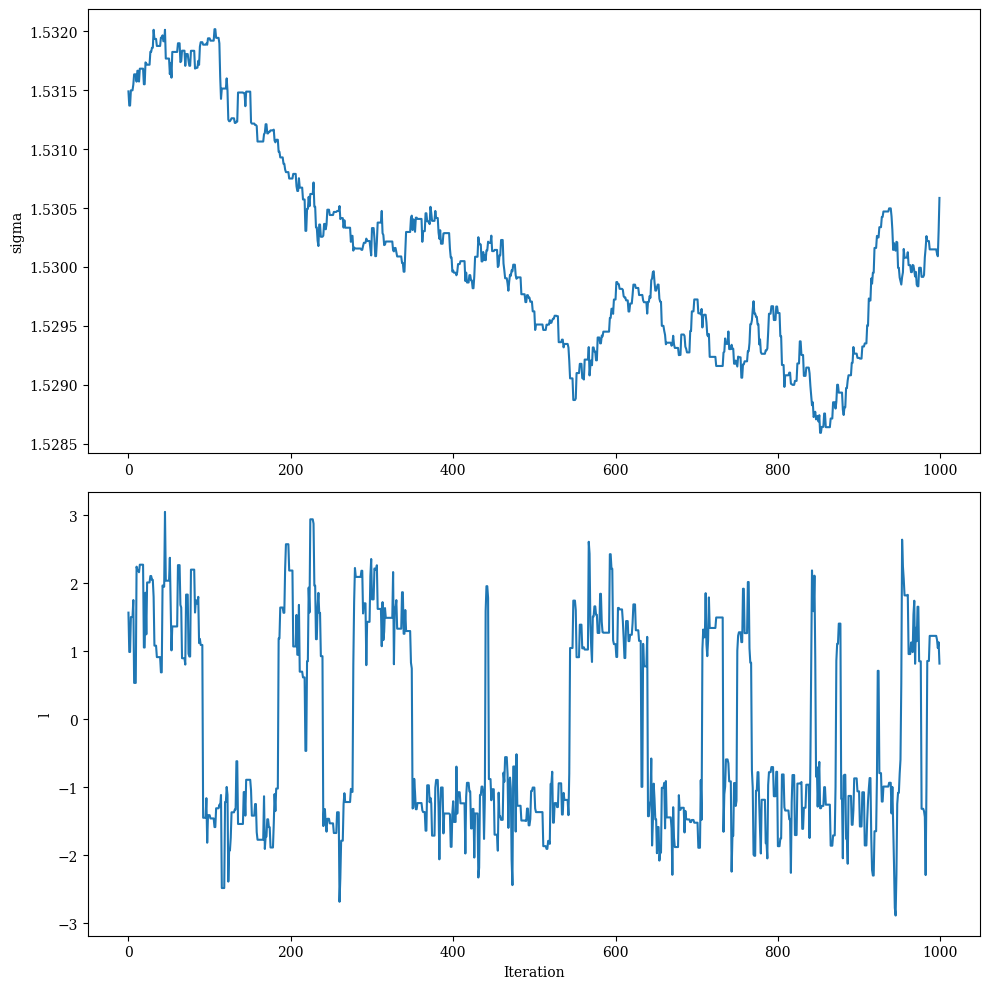

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))


axes[0].plot(samples[:, 0])
axes[0].set_ylabel("sigma")

axes[1].plot(samples[:, 1])
axes[1].set_ylabel("l")

plt.xlabel("Iteration")
plt.tight_layout()
plt.show()